# Challenge Data - Football: qui va gagner ?

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier

In [4]:
base_path = './data'
path_data = './train_team.csv'
path_target = f'{base_path}/Y_train_1rknArQ.csv'

In [5]:
data = pd.read_csv(path_data, sep=',')
target = pd.read_csv(path_target, sep=',')

## Séparation train/test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['ID', 'HOME_LEAGUE', 'HOME_TEAM_NAME', 'AWAY_LEAGUE', 'AWAY_TEAM_NAME']), 
    target, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
    )

In [7]:
print(f"Nombre de données d'entrainement: {X_train.shape[0]}")
print(f"Nombre de données de test: {X_test.shape[0]}")

Nombre de données d'entrainement: 9842
Nombre de données de test: 2461


## Imputation et standardisation des données

In [8]:
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)

Label Encoding de la variable cible (ça sera utile pour certaines modèles)

In [9]:
y_train_encoded = y_train.drop(columns='ID').apply(lambda x: np.where(x.to_numpy() == 1)[0][0], axis=1)
y_test_encoded = y_test.drop(columns='ID').apply(lambda x: np.where(x.to_numpy() == 1)[0][0], axis=1)

## K-Nearest Neighbors

Nous allons performer un grid search sur differents nombres de voisins et différents métriques

In [10]:
n_neighbors = np.arange(5, 150, 5)
param_grid_knn = {
    'n_neighbors': n_neighbors,
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

knn = KNeighborsClassifier(n_jobs=-1)

gs_knn = GridSearchCV(knn, param_grid=param_grid_knn, cv=5, n_jobs=-1, verbose=10).fit(X_train_scaled, y_train_encoded)

Fitting 5 folds for each of 87 candidates, totalling 435 fits


[CV 1/5; 2/87] START metric=euclidean, n_neighbors=10...........................
[CV 1/5; 1/87] START metric=euclidean, n_neighbors=5............................
[CV 3/5; 2/87] START metric=euclidean, n_neighbors=10...........................
[CV 5/5; 1/87] START metric=euclidean, n_neighbors=5............................
[CV 2/5; 2/87] START metric=euclidean, n_neighbors=10...........................
[CV 2/5; 1/87] START metric=euclidean, n_neighbors=5............................
[CV 4/5; 1/87] START metric=euclidean, n_neighbors=5............................
[CV 3/5; 1/87] START metric=euclidean, n_neighbors=5............................
[CV 4/5; 1/87] END metric=euclidean, n_neighbors=5;, score=0.414 total time=   1.0s[CV 3/5; 2/87] END metric=euclidean, n_neighbors=10;, score=0.448 total time=   1.0s
[CV 3/5; 1/87] END metric=euclidean, n_neighbors=5;, score=0.416 total time=   1.0s

[CV 1/5; 1/87] END metric=euclidean, n_neighbors=5;, score=0.430 total time=   1.0s
[CV 5/5; 1/87] 

/home/leonardo/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [11]:
best_params_knn = gs_knn.best_params_
X_test_scaled = scaler.transform(imputer.transform(X_test))
score_knn = gs_knn.score(X_test_scaled, y_test_encoded)

print(f'{best_params_knn=}')
print(f'{score_knn=}')

best_params_knn={'metric': 'euclidean', 'n_neighbors': 120}
score_knn=0.48720032507110933


Text(0.5, 1.0, 'KNN - metric: chebyshev')

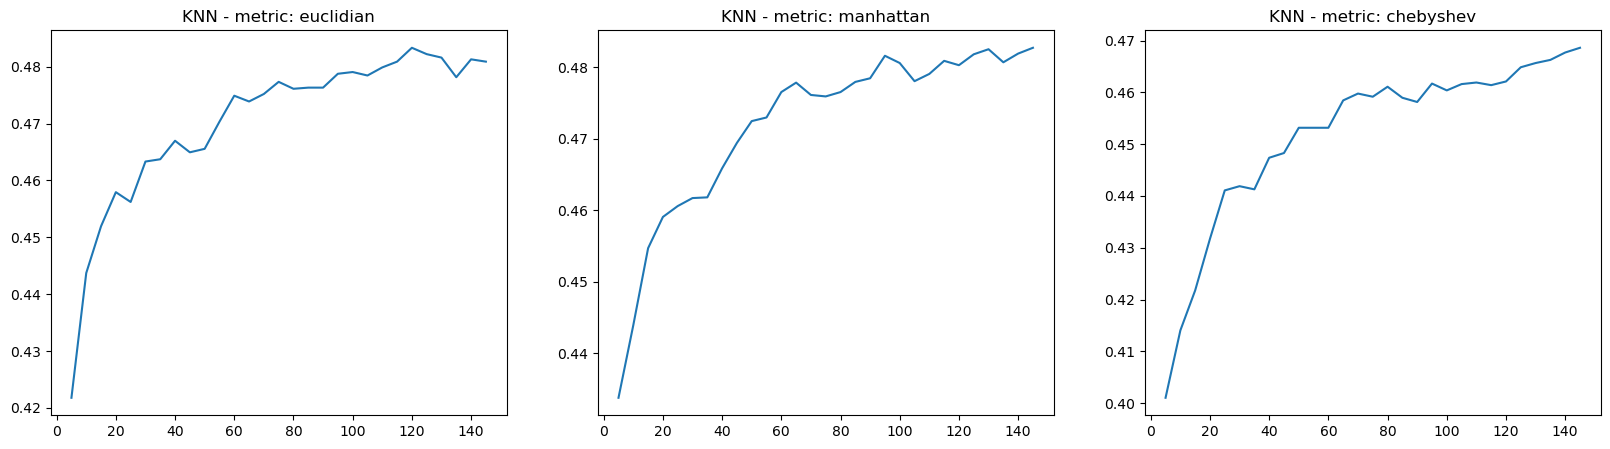

In [ ]:
euclidian = gs_knn.cv_results_['mean_test_score'][:len(n_neighbors)]
manhattan = gs_knn.cv_results_['mean_test_score'][len(n_neighbors):2*len(n_neighbors)]
chebyshev = gs_knn.cv_results_['mean_test_score'][2*len(n_neighbors):]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.plot(n_neighbors, euclidian)
ax1.set_title('KNN - metric: euclidian')
ax2.plot(n_neighbors, manhattan)
ax2.set_title('KNN - metric: manhattan')
ax3.plot(n_neighbors, chebyshev)
ax3.set_title('KNN - metric: chebyshev')

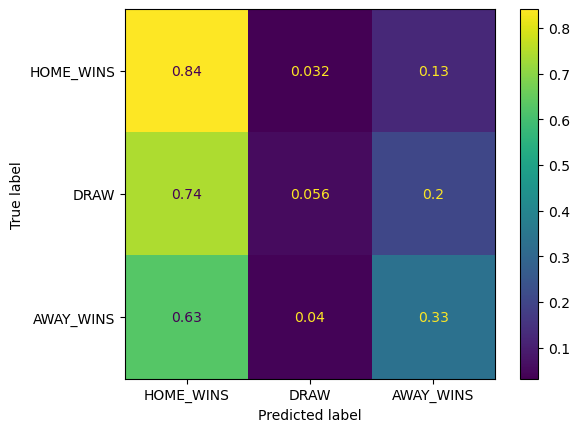

In [ ]:
y_pred = gs_knn.predict(X_test_scaled)
cm = confusion_matrix(y_test_encoded, y_pred, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=['HOME_WINS', 'DRAW', 'AWAY_WINS']).plot()

Nous pouvons remarquer avec les figures ci-dessus l'évolution du score par rapport au nombre de voisins pour chaque métrique utilisé. Nous observons l'effet du overfitting quand nous avons un nombre des voisins faibles. C'est possible de remarquer aussi une stabilisation de l'évolution du score après 100 voisins.

## Regression Logistique

In [90]:
log_reg = LogisticRegression(max_iter=10000, random_state=42)
log_reg.fit(X_train_scaled, y_train_encoded)

LogisticRegression(max_iter=10000, random_state=42)

In [ ]:
y_pred = log_reg.predict(X_test_scaled)
score_reglog = accuracy_score(y_test_encoded, y_pred)
score_reglog

0.481511580658269

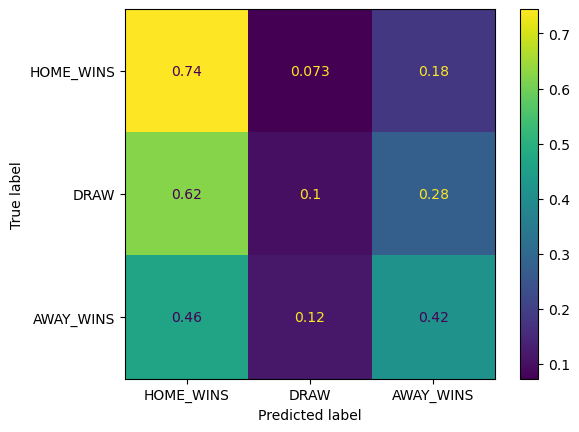

In [92]:
cm_logreg = confusion_matrix(y_test_encoded, y_pred, normalize='true')
ConfusionMatrixDisplay(cm_logreg, display_labels=['HOME_WINS', 'DRAW', 'AWAY_WINS']).plot()

Regression Logistique avec optimisation des hyperparamètres

In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  
    'solver': ['liblinear', 'saga'], 
    'penalty': ['l2'] 
}

In [98]:
gs_log_reg = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gs_log_reg.fit(X_train_scaled, y_train_encoded)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [99]:
best_params = gs_log_reg.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}


In [ ]:
y_pred = gs_log_reg.predict(X_test_scaled)
score_reglog_hyp = accuracy_score(y_test_encoded, y_pred)
score_reglog_hyp

0.4965461194636327

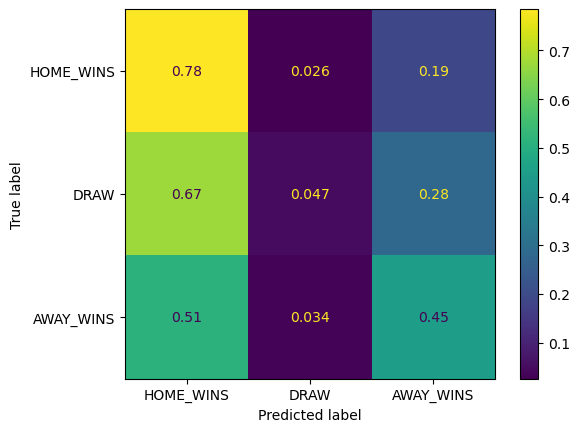

In [101]:
cm_gs_logreg = confusion_matrix(y_test_encoded, y_pred, normalize='true')
ConfusionMatrixDisplay(cm_gs_logreg, display_labels=['HOME_WINS', 'DRAW', 'AWAY_WINS']).plot()

## XGBoost

D'abord, nous allons fixer le taux d'apprentissage et chercher les autres paramètres

In [8]:
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eta=0.1,
    n_estimators=100,
    n_jobs=-1
)

param_grid_xgb = {
    'max_depth': [3, 6, 12],
    'reg_lambda': [0, 0.1, 0.5, 1, 2, 5],
    'reg_alpha': [0, 0.1, 0.5, 1, 2, 5]
}

gs_xgb = GridSearchCV(xgb, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=10).fit(X_train_imp, y_train_encoded)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 4/5; 1/108] START max_depth=3, reg_alpha=0, reg_lambda=0....................
[CV 3/5; 2/108] START max_depth=3, reg_alpha=0, reg_lambda=0.1..................
[CV 3/5; 1/108] START max_depth=3, reg_alpha=0, reg_lambda=0....................
[CV 2/5; 2/108] START max_depth=3, reg_alpha=0, reg_lambda=0.1..................
[CV 5/5; 1/108] START max_depth=3, reg_alpha=0, reg_lambda=0....................
[CV 1/5; 2/108] START max_depth=3, reg_alpha=0, reg_lambda=0.1..................
[CV 2/5; 1/108] START max_depth=3, reg_alpha=0, reg_lambda=0....................
[CV 1/5; 1/108] START max_depth=3, reg_alpha=0, reg_lambda=0....................
[CV 5/5; 1/108] END max_depth=3, reg_alpha=0, reg_lambda=0;, score=0.483 total time=   3.7s
[CV 4/5; 1/108] END max_depth=3, reg_alpha=0, reg_lambda=0;, score=0.471 total time=   3.8s
[CV 4/5; 2/108] START max_depth=3, reg_alpha=0, reg_lambda=0.1..................
[CV 1/5; 1/108] END max_

/home/lucas/miniconda3/envs/data-challenge/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/5; 30/108] END max_depth=3, reg_alpha=2, reg_lambda=5;, score=0.491 total time=   3.6s
[CV 3/5; 31/108] START max_depth=3, reg_alpha=5, reg_lambda=0...................
[CV 2/5; 30/108] END max_depth=3, reg_alpha=2, reg_lambda=5;, score=0.491 total time=   3.8s
[CV 3/5; 30/108] END max_depth=3, reg_alpha=2, reg_lambda=5;, score=0.491 total time=   3.8s
[CV 5/5; 31/108] START max_depth=3, reg_alpha=5, reg_lambda=0...................
[CV 4/5; 30/108] END max_depth=3, reg_alpha=2, reg_lambda=5;, score=0.471 total time=   3.9s
[CV 2/5; 32/108] START max_depth=3, reg_alpha=5, reg_lambda=0.1.................
[CV 5/5; 30/108] END max_depth=3, reg_alpha=2, reg_lambda=5;, score=0.484 total time=   3.9s
[CV 1/5; 32/108] START max_depth=3, reg_alpha=5, reg_lambda=0.1.................
[CV 4/5; 31/108] START max_depth=3, reg_alpha=5, reg_lambda=0...................
[CV 1/5; 31/108] END max_depth=3, reg_alpha=5, reg_lambda=0;, score=0.495 total time=   3.8s
[CV 2/5; 31/108] END max_depth=3, reg

/home/lucas/miniconda3/envs/data-challenge/lib/python3.13/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [11]:
best_params_xgb_tmp = gs_xgb.best_params_
score_xgb_tmp = gs_xgb.score(imputer.transform(X_test), y_test_encoded)

print(f'{best_params_xgb_tmp=}')
print(f'{score_xgb_tmp=}')

best_params_xgb_tmp={'max_depth': 3, 'reg_alpha': 5, 'reg_lambda': 2}
score_xgb_tmp=0.4965461194636327


Maintenant, nous ajustons le taux d'apprentissage

In [23]:
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    n_estimators=100,
    n_jobs=-1,
    max_depth=best_params_xgb_tmp['max_depth'],
    reg_alpha=best_params_xgb_tmp['reg_alpha'],
    reg_lambda=best_params_xgb_tmp['reg_lambda'],
)

param_grid_xgb2 = {
    'eta': [0.01, 0.05, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.22, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

gs_xgb_final = GridSearchCV(xgb, param_grid=param_grid_xgb2, cv=5, n_jobs=-1, verbose=10).fit(X_train_imp, y_train_encoded)

Fitting 5 folds for each of 22 candidates, totalling 110 fits
[CV 1/5; 1/22] START eta=0.01...................................................
[CV 2/5; 1/22] START eta=0.01...................................................
[CV 3/5; 1/22] START eta=0.01...................................................
[CV 4/5; 1/22] START eta=0.01...................................................
[CV 5/5; 1/22] START eta=0.01...................................................
[CV 1/5; 2/22] START eta=0.05...................................................
[CV 2/5; 2/22] START eta=0.05...................................................
[CV 3/5; 2/22] START eta=0.05...................................................
[CV 3/5; 2/22] END ....................eta=0.05;, score=0.484 total time=   4.0s
[CV 4/5; 2/22] START eta=0.05...................................................
[CV 1/5; 2/22] END ....................eta=0.05;, score=0.495 total time=   4.2s
[CV 5/5; 2/22] START eta=0.05..................

/home/lucas/miniconda3/envs/data-challenge/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/5; 12/22] END ...................eta=0.15;, score=0.494 total time=   3.6s
[CV 3/5; 13/22] START eta=0.22..................................................
[CV 3/5; 12/22] END ...................eta=0.15;, score=0.490 total time=   3.0s
[CV 1/5; 13/22] START eta=0.22..................................................
[CV 4/5; 13/22] START eta=0.22..................................................
[CV 2/5; 13/22] START eta=0.22..................................................
[CV 4/5; 12/22] END ...................eta=0.15;, score=0.471 total time=   3.0s
[CV 5/5; 13/22] START eta=0.22..................................................
[CV 5/5; 12/22] END ...................eta=0.15;, score=0.484 total time=   3.0s
[CV 1/5; 14/22] START eta=0.25..................................................
[CV 2/5; 12/22] END ...................eta=0.15;, score=0.489 total time=   3.6s
[CV 2/5; 14/22] START eta=0.25..................................................
[CV 3/5; 13/22] END ........

In [24]:
best_params_xgb = gs_xgb_final.best_params_
score_xgb = gs_xgb_final.score(imputer.transform(X_test), y_test_encoded)

print(f'{best_params_xgb=}')
print(f'{score_xgb=}')

best_params_xgb={'eta': 0.05}
score_xgb=0.49329540837058106


Nous allons analyser l'importance des variables sur cette modèle

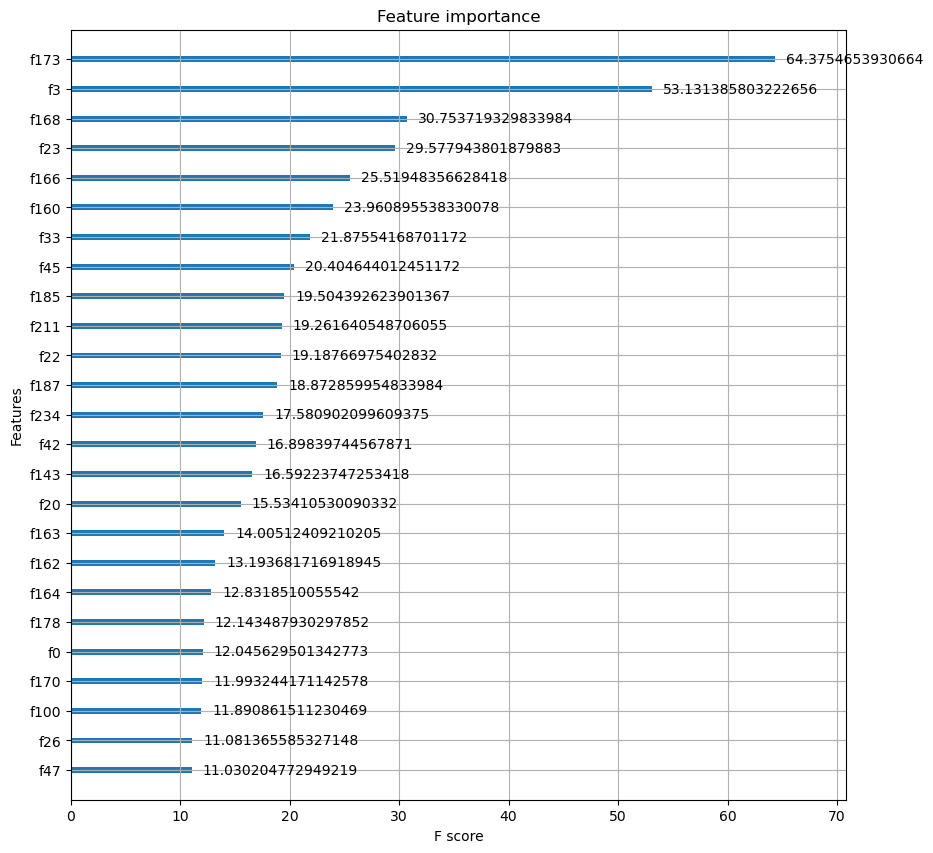

In [44]:
plot_importance(gs_xgb_final.best_estimator_, max_num_features=25, importance_type='gain')
fig = plt.gcf()
fig.set_size_inches(10, 10)

In [58]:
feat_import_idx = np.argsort(gs_xgb_final.best_estimator_.feature_importances_)[::-1]
sorted_feat_import = gs_xgb_final.best_estimator_.feature_importances_[feat_import_idx]

# retrieving features that have more than 1% of importance
most_import = sorted_feat_import[sorted_feat_import > 0.01]
cols_to_keep = X_train.columns[feat_import_idx[:len(most_import)]]

print(f"Nombre de colonnes avec plus de 1% d'importance: {len(cols_to_keep)}")

Nombre de colonnes avec plus de 1% d'importance: 17


Nous allons entraîner un nouvelle modèle en n'utilisant que les variables avec > 1% d'importance

In [69]:
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    n_estimators=100,
    n_jobs=-1,
    max_depth=best_params_xgb_tmp['max_depth'],
    reg_alpha=best_params_xgb_tmp['reg_alpha'],
    reg_lambda=best_params_xgb_tmp['reg_lambda'],
    eta=best_params_xgb['eta']
)

xgb = xgb.fit(
    pd.DataFrame(X_train_imp, columns=X_train.columns)[cols_to_keep],
    y_train_encoded)

In [ ]:
score_xgb_var_imp =  xgb.score(
    pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)[cols_to_keep],
    y_test_encoded)
print(f'{score_xgb_var_imp=}')

0.49451442503047544

## Random Forest

RandomForestClassifier est un modèle basé sur des arbres de décision, qui est intrinsèquement robuste aux valeurs manquantes. Les arbres de décision peuvent diviser le dataset même si certaines caractéristiques sont absentes dans certaines lignes.
Les modèles basés sur des arbres, comme RandomForest, ne nécessitent ni standardisation ni mise à l’échelle des données, car ils ne font aucune hypothèse sur la distribution des caractéristiques ou sur l'échelle des valeurs.
Une éventuelle mise à l’échelle pourrait même être contre-productive, car elle transforme les données sans apporter de bénéfices au modèle.
Il en résulte que l’utilisation de l’imputation et de la mise à l’échelle pourrait altérer la distribution originale des données, qui pourrait pourtant contenir des signaux utiles au modèle.
Dans ce cas, j’utilise donc les données brutes.

In [12]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_clf = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='accuracy')

grid_search_rf.fit(X_train, y_train_encoded)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [13]:
best_params = grid_search_rf.best_params_
print("Best Parameters:", best_params)

best_rf_clf = grid_search_rf.best_estimator_
print("Best Estimator:", best_rf_clf)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best Estimator: RandomForestClassifier(max_depth=10, n_estimators=150, random_state=42)


In [ ]:
y_pred = grid_search_rf.predict(X_test)
score_rf = accuracy_score(y_test_encoded, y_pred)
score_rf

0.49410808614384394

On va analyser l'importance des variables pour le modèle Random Forest

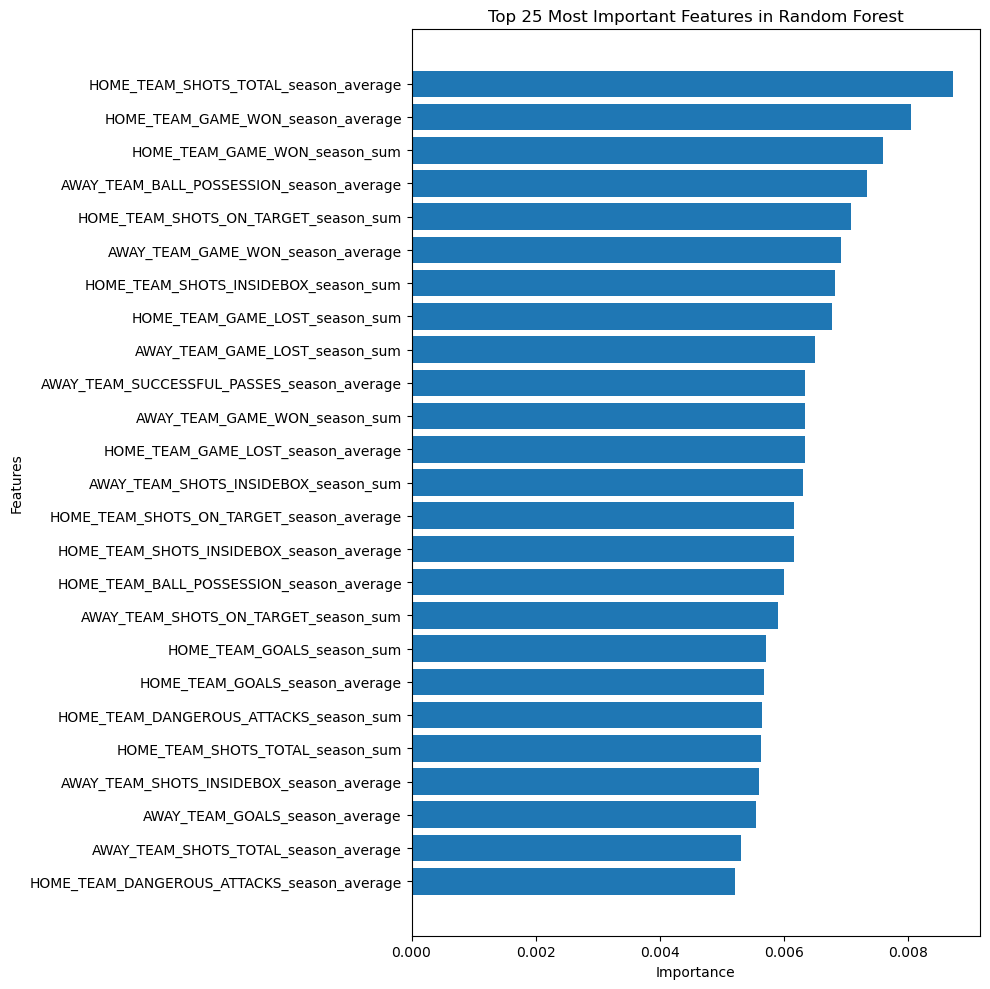

In [15]:
feature_importances = best_rf_clf.feature_importances_

feature_names = X_test.columns if isinstance(X_test, pd.DataFrame) else [f"Feature {i}" for i in range(len(feature_importances))]

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

max_num_features = 25
top_features = importance_df.head(max_num_features)

plt.figure(figsize=(10, 10))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title(f'Top {max_num_features} Most Important Features in Random Forest')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

Entraînement d'un modèle de Random Forest avec uniquement les caractéristiques ayant une importance supérieur au 1%

In [29]:
important_features = importance_df[importance_df['Importance'] > 0.003]
print(f'Ho selezionato {len(important_features)} su un totale di {len(X_test.columns)}')

selected_features = important_features['Feature']

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


Ho selezionato 206 su un totale di 280


In [ ]:
rf_clf_selected = RandomForestClassifier(random_state=42)

grid_search_rf_selected = GridSearchCV(estimator=rf_clf_selected, param_grid=param_grid, 
                                       cv=5, n_jobs=-1, scoring='accuracy')

grid_search_rf_selected.fit(X_train_selected, y_train_encoded)

ValueError: Invalid parameter 'feature_selection' for estimator RandomForestClassifier(random_state=42). Valid parameters are: ['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'].

In [ ]:
best_params_selected = grid_search_rf_selected.best_params_
print("Best Parameters:", best_params_selected)

best_rf_clf_selected = grid_search_rf_selected.best_estimator_
print("Best Estimator:", best_rf_clf_selected)


In [ ]:
y_pred = grid_search_rf_selected.predict(X_test_selected)

score_rf_selected = accuracy_score(y_test_encoded, y_pred)
score_rf_selected

Random Forest with no Bootstrap

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_clf_nb = RandomForestClassifier(random_state=42, bootstrap=False)

grid_search_rf_nb = GridSearchCV(estimator=rf_clf_nb, param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='accuracy')

grid_search_rf_nb.fit(X_train, y_train_encoded)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(bootstrap=False, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [14]:
best_params_nb = grid_search_rf_nb.best_params_
print("Best Parameters:", best_params_nb)

best_rf_clf_nb = grid_search_rf_nb.best_estimator_
print("Best Estimator:", best_rf_clf_nb)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Estimator: RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=2,
                       random_state=42)


In [ ]:
y_pred = grid_search_rf_nb.predict(X_test)
score_rf_nb = accuracy_score(y_test_encoded, y_pred)
score_rf_nb

0.4965461194636327

## LightGBM

In [ ]:
lgb = LGBMClassifier(
    objective='multiclass',
    n_jobs=-1,
    learning_rate=0.1,
    verbosity=-1)

param_grid_lgb = {
    'num_leaves': [3, 4, 5, 6, 7],
    'min_child_samples': [10, 20, 50, 70, 100, 200]
}

gs_lgb = GridSearchCV(lgb, param_grid=param_grid_lgb, cv=5, verbose=10).fit(X_train_imp, y_train_encoded)

In [ ]:
score_lgb = gs_lgb.score(X_test, y_test_encoded)

print(f'{gs_lgb.best_params_=}')
print(f'{score_lgb=}')

## Analyse du Score

In [ ]:
pd.DataFrame(
    {'score': [score_knn, score_xgb, score_xgb_var_imp, score_lgb, score_reglog, score_reglog_hyp, score_rf, score_rf_nb, score_rf_selected]},  
    index=['KNN Score', 'XGB Score', 'XGB Variable Importance Score', 'LGBM Score', 'Reg Logistique Score',
            'Reg Logistique Opt Hyparam', 'Random Forest Score', 'Random Forest No Bootstrap Score', 
            'Random Forest Variable Importance Score']).sort_values(by='score', ascending=False)

## Sousmissions

In [ ]:
data_final = data.drop(columns=['ID', 'HOME_LEAGUE', 'HOME_TEAM_NAME', 'AWAY_LEAGUE', 'AWAY_TEAM_NAME'])
target_encoded = target.drop(columns='ID').apply(lambda x: np.where(x.to_numpy() == 1)[0][0], axis=1)

In [ ]:
final_imputer = SimpleImputer(strategy='median').fit(data_final)
data_imp = final_imputer.transform(data_final)

final_scaler = StandardScaler().fit(data_imp)
data_scaled = scaler.transform(data_imp)

In [ ]:
def generate_test_submission(model, imputer=None, scaler=None, cols_to_keep=None):
    path_team_away_test = f'{base_path}/Test_Data/test_away_team_statistics_df.csv'
    path_team_home_test = f'{base_path}/Test_Data/test_home_team_statistics_df.csv'

    test_team_home = pd.read_csv(path_team_home_test, sep=',')
    test_team_away = pd.read_csv(path_team_away_test, sep=',')

    test_team_home.columns = 'HOME_' + test_team_home.columns
    test_team_away.columns = 'AWAY_' + test_team_away.columns

    test_team =  pd.concat([test_team_home, test_team_away.iloc[:, 1:]],join='inner',axis=1)
    X_test = test_team.rename(columns={'HOME_ID':'ID'})

    X_test_id = X_test['ID']
    X_test = X_test.drop(columns=['ID'])
    original_columns = X_test.columns

    if imputer is not None:
        X_test = imputer.transform(X_test)

    if scaler is not None:
        X_test = scaler.transform(X_test)

    if cols_to_keep is not None:
        X_test = pd.DataFrame(X_test, columns=original_columns)[cols_to_keep]

    predictions = model.predict(X_test)        

    p = []
    for pred in predictions:
        _p = np.zeros(3, dtype=np.int32)
        _p[pred] = 1
        p.append(_p)

    pred_sub = pd.DataFrame(data=p, columns=['HOME_WINS', 'DRAW', 'AWAY_WINS'])
    pred_sub = pd.concat([X_test_id, pred_sub],join='inner',axis=1)

    return pred_sub

In [ ]:
lgbm_sub = generate_test_submission(
    model=LGBMClassifier(
        objective='multiclass',
        n_jobs=-1,
        learning_rate=0.1,
        verbosity=-1,
        min_child_samples=10, 
        num_leaves=3
    ).fit(data_imp, target_encoded),
    imputer=final_imputer
)
lgbm_sub.to_csv('./submission_lgbm.csv', index=False)

In [ ]:
xgb_var_import_sub = generate_test_submission(xgb, imputer=imputer, cols_to_keep=cols_to_keep)
xgb_var_import_sub.to_csv('./submission_xgb_var.csv', index=False)

In [ ]:
reg_log_sub = generate_test_submission(log_reg, imputer=imputer, scaler=scaler)
reg_log_sub.to_csv('./submission_reglog.csv', index=False)

In [ ]:
gs_log_reg_sub = generate_test_submission(gs_log_reg, imputer=imputer, scaler=scaler)
gs_log_reg_sub.to_csv('./submission_reglog_var.csv', index=False)

In [ ]:
grid_search_rf_nb_sub = generate_test_submission(grid_search_rf)
grid_search_rf_nb_sub.to_csv('./submission_randomforest.csv', index=False)

In [ ]:
grid_search_rf_nb_sub = generate_test_submission(grid_search_rf_nb)
grid_search_rf_nb_sub.to_csv('./submission_randomforest_nobootstrap.csv', index=False)

In [ ]:
grid_search_rf_selected_sub = generate_test_submission(grid_search_rf_selected)
grid_search_rf_nb_sub.to_csv('./submission_randomforest_var.csv', index=False)